<a href="https://www.kaggle.com/code/shuric80/birdclef-2022-pytorch?scriptVersionId=92486807" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="background-color:#f3ab60;font-family:newtimeroman;color:#662e2e;font-size:130%;text-align:center;border-radius:40px 40px;">BirdCLEF 2022</p>

<h1 align='center'>Introduction 📝</h1>
The goal of the competition is to identify which birds are calling in the recordings. This notebook will be helpful for all the begineers who have very little to no knowledge in this domain. In this kernel I will briefly go through the metadata and audio data with some quick EDA. Then I will focus on the main part of the kernel which is the data processing and training audio based data model using pytorch. 

This is a work in progress notebook and I will keep on updating it as I learn more (as I have also participated in the audio based competition for the first time😅)

##  <font color="red"> Please do an upvote if you find this kernel useful.</font>

<h1 align='center'>Table of Contents 📜</h1>
<ul style="list-style-type:square">
    <li><a href="#1">Importing Libraries</a></li>
    <li><a href="#2">Reading the data</a></li>
    <li><a href="#3">Quick EDA</a></li>
    <ul style="list-style-type:disc">
        <li><a href="#3.1">Train_Metadata</a></li>
        <li><a href="#3.2">Audio Files</a></li>
    </ul>
    <li><a href="#4">Data Preprocessing</a></li>
    <li><a href="#5">Model</a></li>
    <li><a href="#6">Utility Functions</a></li>
    <li><a href="#7">Training</a></li>
</ul>



<a id='1'></a>
# Importing Libraries 📚

In [1]:
import os
import gc
import ast
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import torchaudio
import IPython.display as ipd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models

import warnings
warnings.filterwarnings('ignore')

In [2]:
class config:
    seed=2022
    num_fold = 5
    sample_rate= 32_000
    n_fft=1024
    hop_length=512
    n_mels=64
    duration=7
    num_classes = 152
    train_batch_size = 32
    valid_batch_size = 64
    model_name = 'resnet50'
    epochs = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-4

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(config.seed)

<a id='2'></a>
# Reading the data 📖

In [4]:
df = pd.read_csv('../input/birdclef-2022/train_metadata.csv')
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14852 entries, 0 to 14851
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     14852 non-null  object 
 1   secondary_labels  14852 non-null  object 
 2   type              14852 non-null  object 
 3   latitude          14852 non-null  float64
 4   longitude         14852 non-null  float64
 5   scientific_name   14852 non-null  object 
 6   common_name       14852 non-null  object 
 7   author            14852 non-null  object 
 8   license           14852 non-null  object 
 9   rating            14852 non-null  float64
 10  time              14852 non-null  object 
 11  url               14852 non-null  object 
 12  filename          14852 non-null  object 
dtypes: float64(3), object(10)
memory usage: 1.5+ MB


In [6]:
df.describe()

,latitude,longitude,rating
count,14852.000000,14852.000000,14852.000000
mean,35.778958,-30.217719,3.719129
std,22.288169,73.679144,1.181014
min,-71.883400,-176.632200,0.000000
25%,28.259200,-96.164300,3.000000
50%,40.870800,-6.061100,4.000000
75%,51.121950,10.897800,4.500000
max,78.978300,179.360700,5.000000


<a id='3'></a>
# Quick EDA 📊

<a id='3.1'></a>
## Analyse Train_Metadata

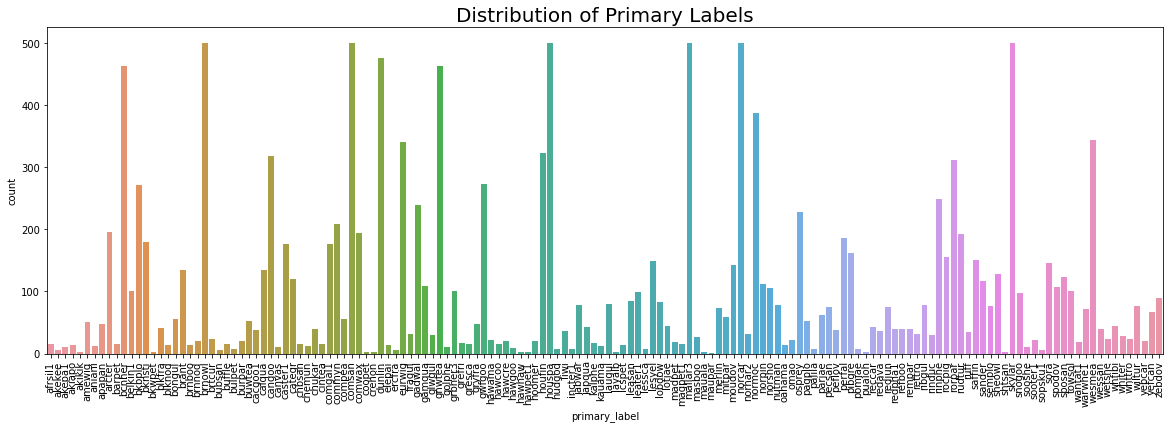

In [7]:
plt.figure(figsize=(20, 6))

sns.countplot(df['primary_label'])
plt.xticks(rotation=90)
plt.title("Distribution of Primary Labels", fontsize=20)

plt.show()

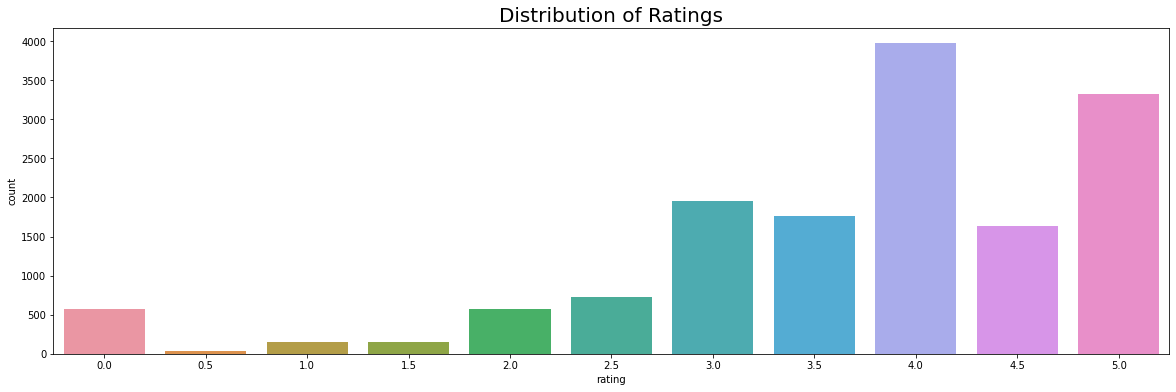

In [8]:
plt.figure(figsize=(20, 6))

sns.countplot(df['rating'])
plt.title("Distribution of Ratings", fontsize=20)

plt.show()

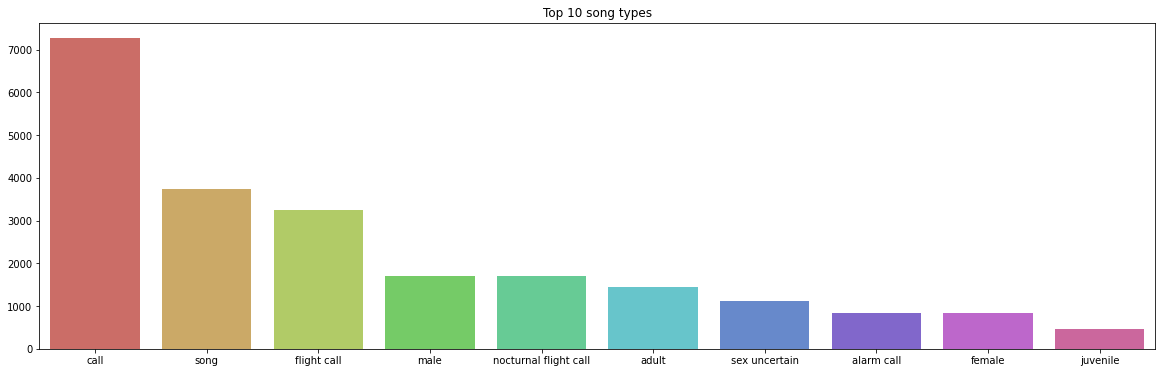

In [9]:
df['type'] = df['type'].apply(lambda x : ast.literal_eval(x))

top = Counter([typ.lower() for lst in df['type'] for typ in lst])

top = dict(top.most_common(10))

plt.figure(figsize=(20, 6))

sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
plt.title("Top 10 song types")

plt.show()

<a id='3.2'></a>
## Analyse Audio Files

### Let's listen few audios

In [10]:
filename_1 = df["filename"].values[0] # first training example
ipd.Audio(f"../input/birdclef-2022/train_audio/{filename_1}")

In [11]:
filename_2 = df["filename"].values[-1] # last training example
ipd.Audio(f"../input/birdclef-2022/train_audio/{filename_2}")

### Now let us load the the audio and plot the waveform.
<b>Note - I will be using Torchaudio(which is a library for audio with PyTorch) for processing audio data.</b><br>
<center>
<img src = "https://torch.mlverse.org/css/images/hex/torchaudio.png" style="width:200px;height:200px"><br>
<a href="https://pytorch.org/audio/stable/index.html">TORCHAUDIO DOCUMENTATION</a>    
</center>

[](http://)

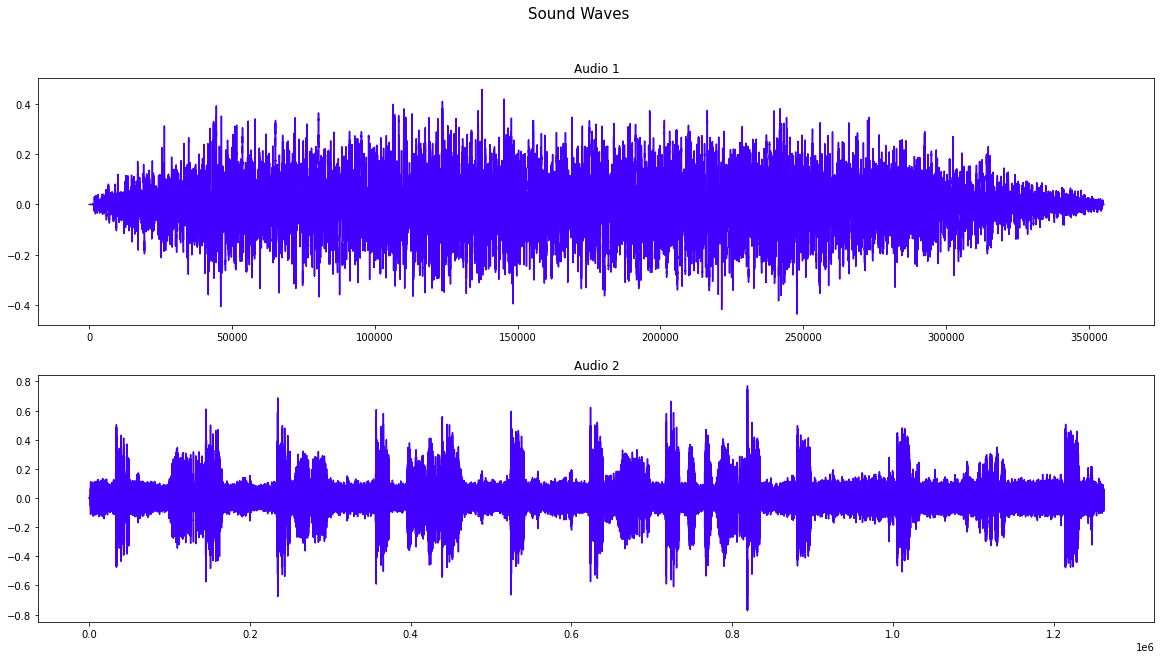

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle("Sound Waves", fontsize=15)

signal_1, sr = torchaudio.load(f"../input/birdclef-2022/train_audio/{filename_1}")
# The audio data consist of two things-
# Sound: sequence of vibrations in varying pressure strengths (y)
# Sample Rate: (sr) is the number of samples of audio carried per second, measured in Hz or kHz

sns.lineplot(x=np.arange(len(signal_1[0,:].detach().numpy())), y=signal_1[0,:].detach().numpy(), ax=ax[0], color='#4400FF')
ax[0].set_title("Audio 1")

signal_2, sr = torchaudio.load(f"../input/birdclef-2022/train_audio/{filename_2}")
sns.lineplot(x=np.arange(len(signal_2[0,:].detach().numpy())), y=signal_2[0,:].detach().numpy(), ax=ax[1], color='#4400FF')
ax[1].set_title("Audio 2")

plt.show()

<a id='4'></a>
# Dataset Preprocessing 🛠️

### First of all, as our target variable is in string format, we have to convert it to integer and here I have used LabelEncoder to perform this work.

In [13]:
encoder = LabelEncoder()
df['primary_label_encoded'] = encoder.fit_transform(df['primary_label'])

### Next we created folds.

In [14]:
skf = StratifiedKFold(n_splits=config.num_fold)
for k, (_, val_ind) in enumerate(skf.split(X=df, y=df['primary_label_encoded'])):
    df.loc[val_ind, 'fold'] = k

Now we will focus on our input variable. Our input in this are audio files and these audios cannot be understood by the models directly. So to use them, we convert it into an understandable format by performing some type of feature extraction technique.

## Feature Extraction
There are several different feature extractions in audio processing but I will not cover all those in this notebook. Genereally, the features that are extracted are in the form of images which we then use them to train our model. <br>
I would recommed this playlist for audio processing to understand the basics - https://www.youtube.com/playlist?list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0 <br>
Here I will be extracting MelSpectrogram which is a type of spectrogram where the frequencies are converted to the mel scale.

### Now let us look at the Mel Spectrogram for the audio loaded during the EDA.

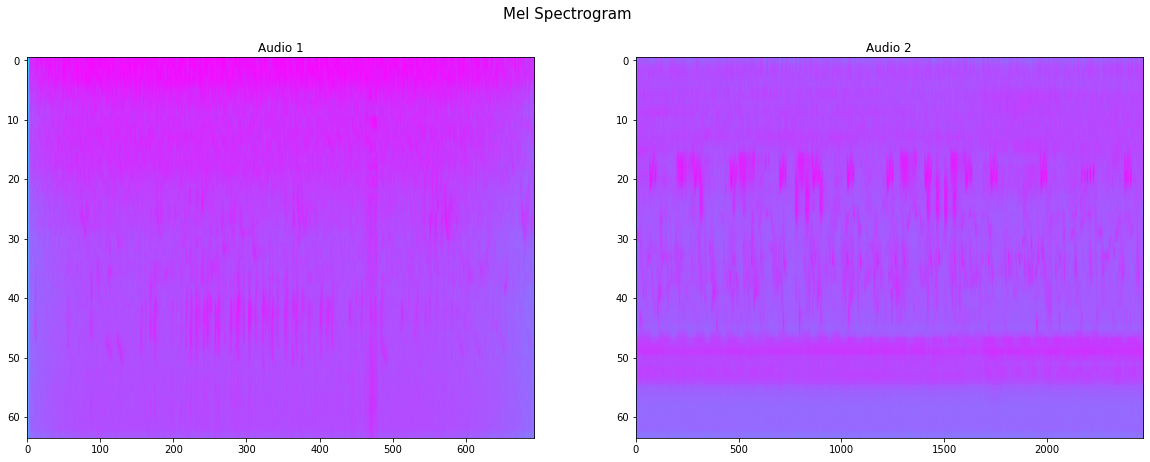

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Mel Spectrogram", fontsize=15)

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config.sample_rate, 
                                                      n_fft=config.n_fft, 
                                                      hop_length=config.hop_length, 
                                                      n_mels=config.n_mels)

mel_1 = mel_spectrogram(signal_1)
ax[0].imshow(mel_1.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
ax[0].set_title("Audio 1")

mel_2 = mel_spectrogram(signal_2)
ax[1].imshow(mel_2.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
ax[1].set_title("Audio 2")

plt.show()

### So similarly we will extract mel spectrogram for each audio and will train the model using them. But wait, this is not the end. There are several things which we need to consider before extracting spectrograms from the audio files. We want our dataset to be uniform and to do that we should consider the below points:-
* As I mentioned above the audio data consist of two things - sample rate and sound. Not all the audio have same sample rate, and this is a huge problem if we want uniformity in the melspectrogram which we extract. So we resample the data so that all the data have same sample rates.
* Next if we talk about the sound, the dimension of sound is - (num_channels, num_samples). If we talk about number of channels, then each audio signals can have different number of channels. So we will ensure that they are mono, i.e., num_channels = 1.
* Lastly, each audio signal have different time durations which lead to difference in number of samples. So we ensure same number of samples by applying padding if it is less than the desired samples or by truncating if it is more than the desired samples.

### Now I will implement the custom Dataset class in which I will also implement all the above points. 

In [16]:
def filter_low_pass(y,sr):
    from scipy.fft import fft, fftfreq, ifft
    SAMPLE_RATE = 1
    DURATION = len(y) / SAMPLE_RATE
    N = int(SAMPLE_RATE * DURATION)

    yf = fft(y)
    xf = fftfreq(N, 1 / SAMPLE_RATE)
    new_yf = yf.copy()
    middle = len(y) / 2
    new_yf[int(middle - len(y) * th):int(middle + len(y) * th)] = 0
    new_y = ifft(new_yf)
    new_y = new_y.real
    return new_y, sr

In [17]:
class BirdClefDataset(Dataset):
    def __init__(self, df, transformation, target_sample_rate, duration):
        self.audio_paths = df['filename'].values
        self.labels = df['primary_label_encoded'].values
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate*duration
        
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, index):
        audio_path = f'../input/birdclef-2022/train_audio/{self.audio_paths[index]}'
        signal, sr = torchaudio.load(audio_path) # loaded the audio
#         signal, sr = filter_low_pass(signal, sr)
        
        # Now we first checked if the sample rate is same as TARGET_SAMPLE_RATE and if it not equal we perform resampling
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        
        # Next we check the number of channels of the signal
        #signal -> (num_channels, num_samples) - Eg.-(2, 14000) -> (1, 14000)
        if signal.shape[0]>1:
            signal = torch.mean(signal, axis=0, keepdim=True)
        
        # Lastly we check the number of samples of the signal
        #signal -> (num_channels, num_samples) - Eg.-(1, 14000) -> (1, self.num_samples)
        # If it is more than the required number of samples, we truncate the signal
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        
        # If it is less than the required number of samples, we pad the signal
        if signal.shape[1]<self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = F.pad(signal, last_dim_padding)
        
        # Finally all the process has been done and now we will extract mel spectrogram from the signal
        mel = self.transformation(signal)
        
        # For pretrained models, we need 3 channel image, so for that we concatenate the extracted mel
        image = torch.cat([mel, mel, mel])
        
        # Normalized the image
        max_val = torch.abs(image).max()
        image = image / max_val
        
        label = torch.tensor(self.labels[index])
        
        return image, label

In [18]:
# Function to get data according to the folds
def get_data(fold):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    
    train_dataset = BirdClefDataset(train_df, mel_spectrogram, config.sample_rate, config.duration)
    valid_dataset = BirdClefDataset(valid_df, mel_spectrogram, config.sample_rate, config.duration)
    
    train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config.valid_batch_size, shuffle=False)
    
    return train_loader, valid_loader

<a id='5'></a>
# Model 🤖

### So I will first start with a custom CNN model. After that, we will the see the usage of pretrained and other advanced models.

In [19]:
class BirdClefModel(nn.Module):
    def __init__(self):
        super(BirdClefModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128*8*54, 64)
        self.fc2 = nn.Linear(64, config.num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

### Now we will fine tune a pretrained model. Here I have used Resnet50. You can use any pretrained model and do experiments.

In [20]:
class BirdCLEFResnet(nn.Module):
    def __init__(self):
        super(BirdCLEFResnet, self).__init__()
        self.base_model = models.__getattribute__(config.model_name)(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        in_features = self.base_model.fc.in_features
        
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 1024), 
            nn.ReLU(), 
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Dropout(p=0.2),
            nn.Linear(512, config.num_classes))
        
    def forward(self, x):
        x = self.base_model(x)
        return x

<a id='6'></a>
# Utility Functions 📋

### Next we define some functions to train the model. These are the basic functions which we use to train any pytorch based models.

In [21]:
def loss_fn(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

def train(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()
    
    running_loss = 0
    loop = tqdm(data_loader, position=0)
    for i, (mels, labels) in enumerate(loop):
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
            
        running_loss += loss.item()
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())

    return running_loss/len(data_loader)

In [22]:
def valid(model, data_loader, device, epoch):
    model.eval()
    
    running_loss = 0
    pred = []
    label = []
    
    loop = tqdm(data_loader, position=0)
    for mels, labels in loop:
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
            
        running_loss += loss.item()
        
        pred.extend(preds.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())
        
    valid_f1 = f1_score(label, pred, average='macro')
    
    return running_loss/len(data_loader), valid_f1

In [23]:
def run(fold):
    train_loader, valid_loader = get_data(fold)
    
    #model = BirdClefModel().to(config.device) # check version 3 for this
    model = BirdCLEFResnet().to(config.device)
    
    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=10)
    
    best_valid_f1 = 0
    for epoch in range(config.epochs):
        train_loss = train(model, train_loader, optimizer, scheduler, config.device, epoch)
        valid_loss, valid_f1 = valid(model, valid_loader, config.device, epoch)
        if valid_f1 > best_valid_f1:
            print(f"Validation F1 Improved - {best_valid_f1} ---> {valid_f1}")
            torch.save(model.state_dict(), f'./model_{fold}.bin')
            print(f"Saved model checkpoint at ./model_{fold}.bin")
            best_valid_f1 = valid_f1
            
    return best_valid_f1

GB
GB
GB
GB
GB
GB
GB
GB
GB
GB
GB
<a id='7'></a>
# Training ⚙️

In [24]:
for fold in range(config.num_fold):
    print("=" * 30)
    print("Training Fold - ", fold)
    print("=" * 30)
    best_valid_f1 = run(fold)
    print(f'Best F1 Score: {best_valid_f1:.5f}')
    
    gc.collect()
    torch.cuda.empty_cache()    
    break # To run for all the folds, just remove this break

Training Fold -  0


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch [1/2]: 100%|██████████| 47/47 [03:56<00:00,  5.04s/it, loss=5.27]


Validation F1 Improved - 0 ---> 0.011453940836640988
Saved model checkpoint at ./model_0.bin


Epoch [2/2]: 100%|██████████| 47/47 [03:28<00:00,  4.44s/it, loss=5.02]


Validation F1 Improved - 0.011453940836640988 ---> 0.013825125878171293
Saved model checkpoint at ./model_0.bin
Best F1 Score: 0.01383


<div class="alert alert-block alert-warning">
    <h2 align='center'>🚧WORK IN PROGRESS🚧</h2>
    <h3 align='center'>Please consider upvoting the kernel if you found it useful.</h3>
</div>